In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sb
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp

from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from mpl_toolkits.mplot3d import axes3d
from pylab import rcParams
#%matplotlib notebook

In [2]:
clases=['muon','electron','piminus']

In [3]:
f = h5py.File('dataset_test.h5', 'r')

keys = ['E', 'azimuth', 'cycle', 'eff', 'enter.x', 'enter.y', 'enter.z', 'evt', 'exit.x', 'exit.y', 'exit.z', 'index',
        'nhitslc', 'nhittot', 'p.E', 'p.px', 'p.py', 'p.pz', 'pdg', 'penter.E', 'penter.px', 'penter.py', 'penter.pz',
        'rec.mc.cosmic_idx', 'run', 'stop.x', 'stop.y', 'stop.z', 'subevt', 'subrun', 'time', 'visE', 'visEinslc',
        'vtx.x', 'vtx.y', 'vtx.z', 'zenith']
data = {}
for k in keys:
    data[k] = np.array(f[k])
data = pd.DataFrame(data)
data['euclidean'] = (((data['vtx.x'] - data['stop.x']) ** 2) +
                     (data['vtx.x'] - data['stop.x']) ** 2 +
                     (data['vtx.z'] - data['stop.z']) ** 2) ** .5


def set_values(row, value):
    return value[row]


map_dictionary = {11: "electron", 13: "muon", -211: "piminus"}

data['label_true'] = data['pdg'].apply(set_values, args=(map_dictionary,))
f.close()

In [4]:
f = h5py.File('logs/predictions_default.h5', 'r')
pred = {'run':np.array(f['runs']),
        'subrun':np.array(f['subruns']),
        'evt':np.array(f['evts']),
        'label':np.array(f['labels']),
        'cycle':np.array(f['cycles']),}
probs = pd.DataFrame(np.array(f['probs']), columns=['pdm', 'pde', 'pdp'])
probs['y_preds']= np.argmax(np.array(f['probs']), axis=1)
probs['predict']=probs['y_preds'].apply(lambda x: clases[x])

dfpred = pd.DataFrame(pred)
dfpred = pd.concat([dfpred, probs], axis=1, join='inner').reset_index()
dfpred = pd.merge(dfpred, data, on=['run', 'subrun', 'cycle', 'evt'], how='inner')

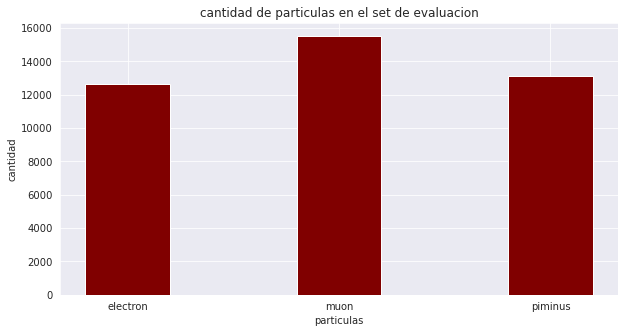

In [5]:

part = list(dfpred.groupby("label_true")["label_true"].count().keys())
cant = list(dfpred.groupby("label_true")["label_true"].count().values)

fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(part, cant, color='maroon', width=0.4)

plt.xlabel("particulas")
plt.ylabel("cantidad")
plt.title("cantidad de particulas en el set de evaluacion")
plt.savefig("./plots/dist_eval.png")

              precision    recall  f1-score   support

        muon       0.80      0.72      0.76     15524
    electron       0.63      0.71      0.67     12651
     piminus       0.68      0.68      0.68     13121

    accuracy                           0.71     41296
   macro avg       0.71      0.70      0.70     41296
weighted avg       0.71      0.71      0.71     41296



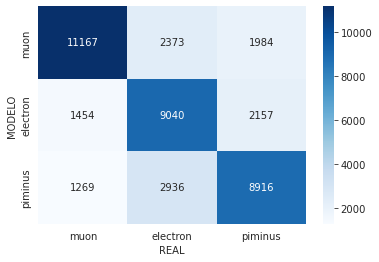

In [6]:
CM = confusion_matrix(dfpred['label'],dfpred['y_preds'])
print(classification_report(dfpred['label'],dfpred['y_preds'], target_names=['muon', 'electron', 'piminus']))
#print(CM)
dfmat = pd.DataFrame(CM, index=clases, columns=clases)
grafica = sb.heatmap(dfmat, cmap='Blues', annot=True, fmt='g')
grafica.set(xlabel='REAL', ylabel='MODELO')
plt.savefig('plots/confucion.png')
plt.show()

/tmp/ipykernel_86873/3081884188.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


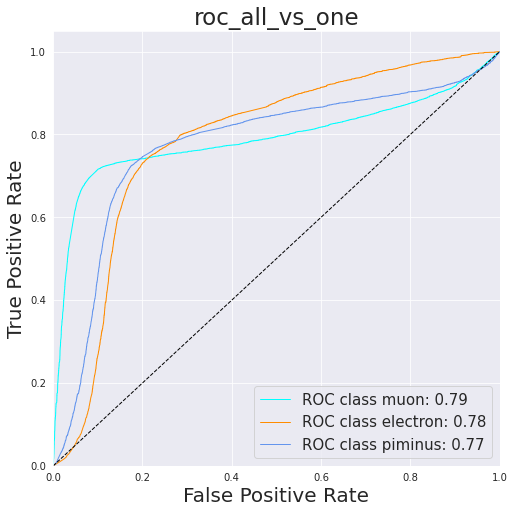

In [7]:
# Binarize the output
y_test = label_binarize(dfpred['label_true'], classes=clases)
n_classes = y_test.shape[1]
y_score = dfpred[["pdm", "pde", "pdp"]].values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC class ' + clases[i] + ': ' + str(roc_auc[i])[
                                                                                        0:4])  #ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('roc_all_vs_one', fontsize=23)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig("plots/roc_all_vs_one.jpg")
plt.show()

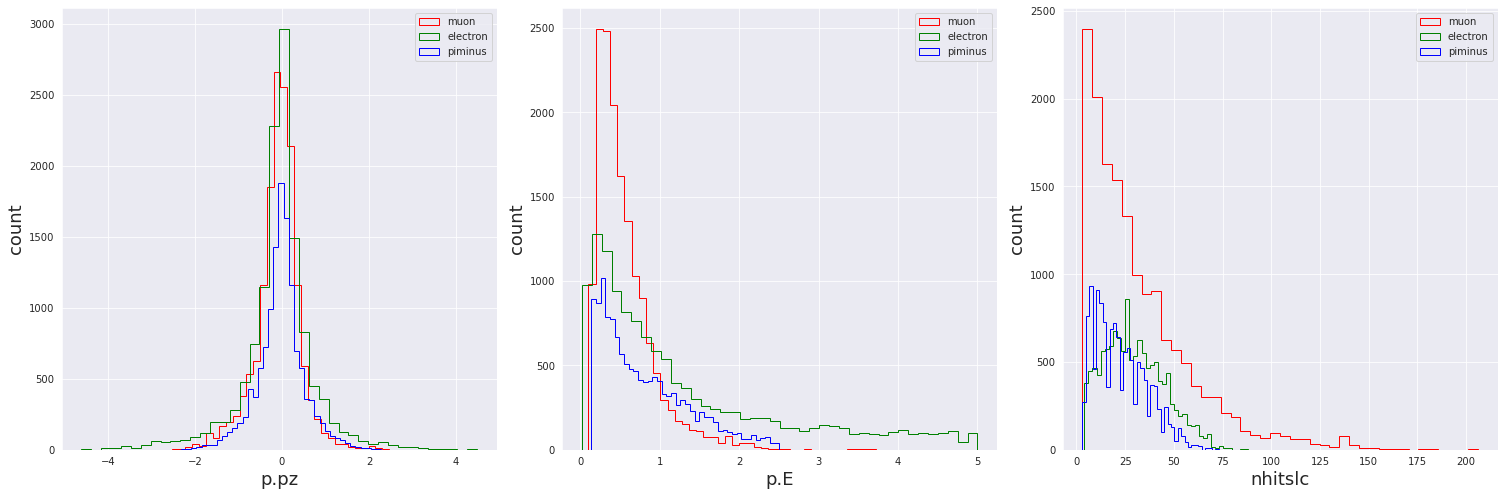

In [8]:

rcParams['figure.figsize'] = 21, 7
fig, axes = plt.subplots(nrows=1, ncols=3)
colors = ["red", "green", "blue", "yellow", "pink", "orange"]
for prop, ax in zip(['p.pz', 'p.E', 'nhitslc'], axes):
    for label, color in zip(['muon', 'electron', 'piminus'], ["red", "green", "blue"]):
        ax.hist((dfpred[dfpred['label_true'] == label])[prop], 40, histtype='step', stacked=True, fill=False,
                color=color, label=label)
        #ax.set_title(label, size=20)
        ax.set_ylabel('count', size=18)
        ax.set_xlabel(prop, size=18)
        ax.legend()
        ax.grid(True)

fig.tight_layout()
plt.savefig('plots/dist_prop_label.jpg')
plt.show()

/tmp/ipykernel_86873/2595270191.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_86873/2595270191.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_86873/2595270191.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')


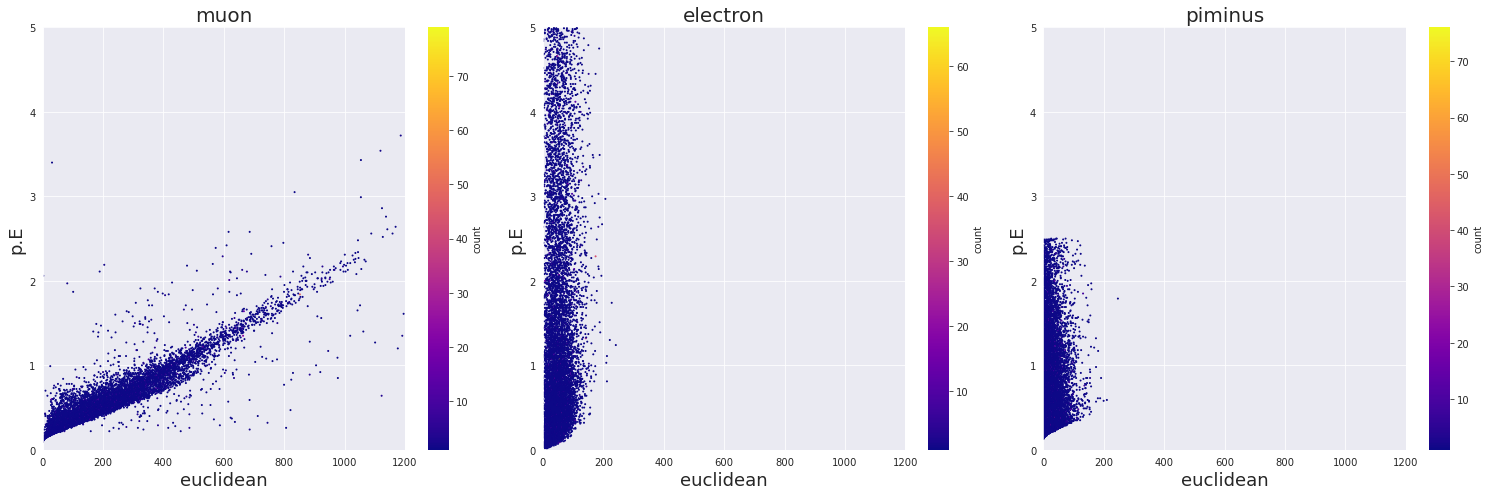

In [9]:

rcParams['figure.figsize'] = 21, 7
fig, axes = plt.subplots(nrows=1, ncols=3)
for label, prob, ax in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    df = (dfpred[dfpred['label_true'] == label])[['euclidean', 'p.E']]
    df = np.trunc(100 * df) / 100
    df = df.groupby(['euclidean', 'p.E']).size().reset_index(name='counts')
    colors = df['counts']
    p = ax.scatter(df['euclidean'], df['p.E'], s=1, vmin=1, vmax=colors.max(), c=colors, cmap='plasma')

    ax.set_title(label, size=20)
    ax.set_ylabel('p.E', size=18)
    ax.set_xlabel('euclidean', size=18)
    ax.set_xlim(0, 1200)
    ax.set_ylim(0, 5)
    ax.grid(True)
    cb = fig.colorbar(p, ax=ax, label='count')
    cb.outline.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('plots/euclidean_vs_prop.jpg')
plt.show()

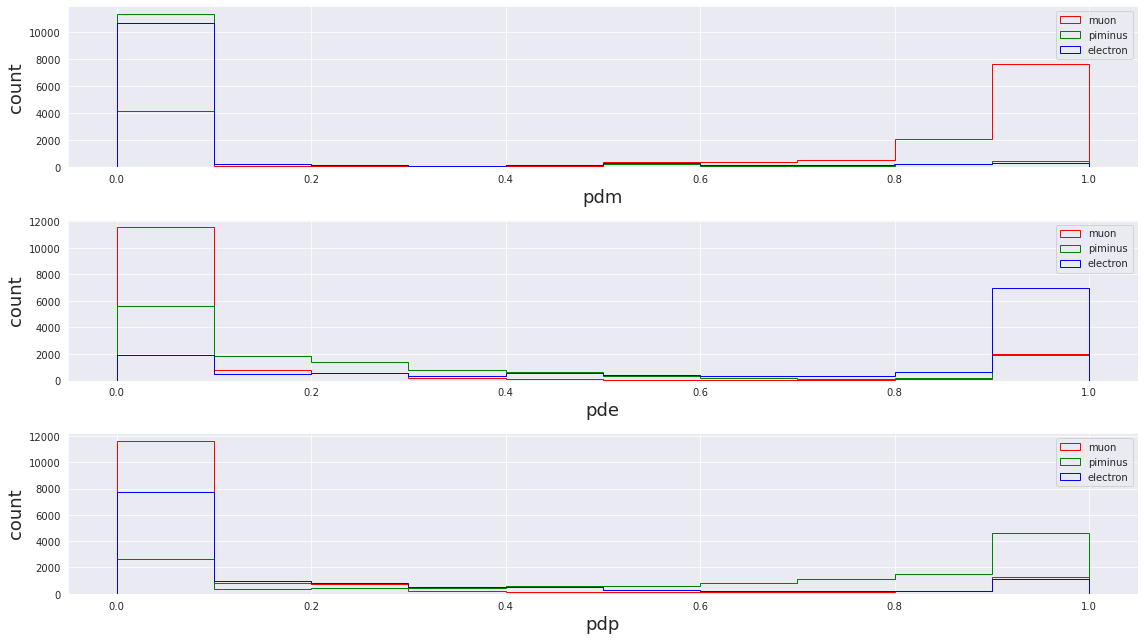

In [10]:
rcParams['figure.figsize'] = 16, 9
fig, axes = plt.subplots(nrows=3, ncols=1)
for prob, ax in zip(['pdm', 'pde', 'pdp'], axes):
    for label, color in zip(list(dfpred['label_true'].drop_duplicates()), ["red", "green", "blue"]):
        ax.hist((dfpred[dfpred['label_true'] == label])[prob], 10, histtype='step', stacked=True, fill=False,
                color=color, label=label)

        ax.legend()
        ax.set_xlabel(prob, size=18)
        ax.set_ylabel('count', size=18)
fig.tight_layout()
plt.savefig('plots/dist_score_label.jpg')
plt.show()

/tmp/ipykernel_86873/114527177.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_86873/114527177.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_86873/114527177.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_86873/114527177.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid

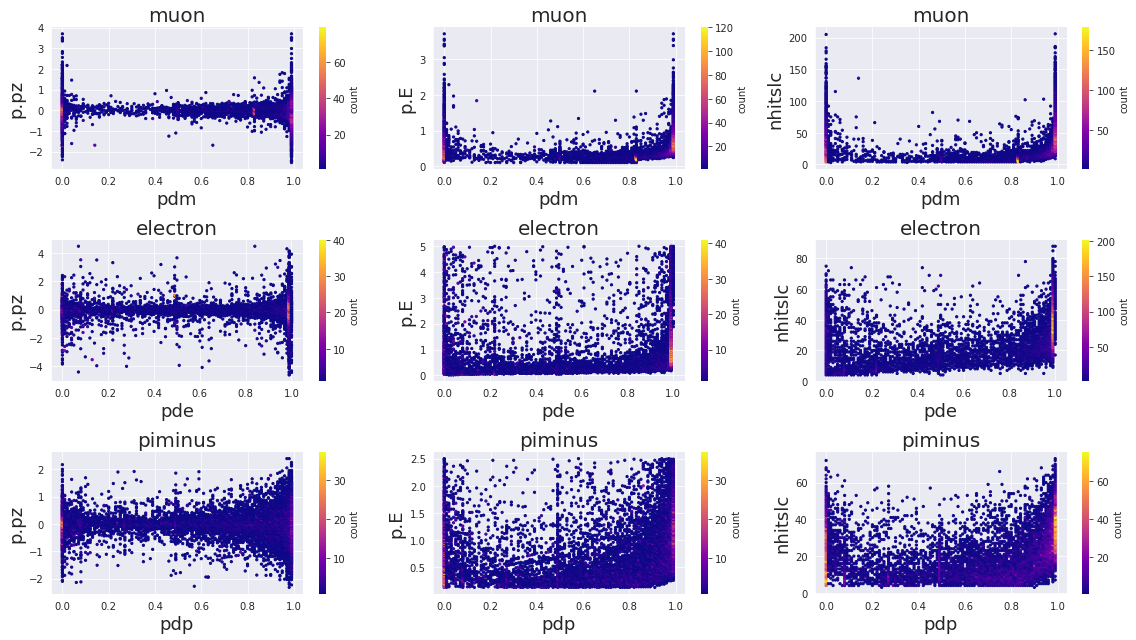

In [11]:
rcParams['figure.figsize'] = 16, 9
fig, axes = plt.subplots(nrows=3, ncols=3)
colors = ["red", "green", "blue", "yellow", "pink", "orange"]
for label, prob, filas in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    for prop, ax in zip(['p.pz', 'p.E', 'nhitslc'], filas):
        df = (dfpred[dfpred['label_true'] == label])[[prop, prob]]
        df = np.trunc(100 * df) / 100
        df = df.groupby([prob, prop]).size().reset_index(name='counts')
        colors = df['counts']
        p = ax.scatter(df[prob], df[prop], s=5, vmin=1, vmax=colors.max(), c=colors, cmap='plasma')

        ax.set_title(label, size=20)
        ax.set_ylabel(prop, size=18)
        ax.set_xlabel(prob, size=18)

        ax.grid(True)
        cb = fig.colorbar(p, ax=ax, label='count')
        cb.outline.set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('plots/score_vs_prop.jpg')
plt.show()